In [156]:
import tensorflow as tf
import pandas as pd
from window import WindowGenerator
from utils import train_test_val_split

# LSTM

## Datasets

In [157]:
case_1 = pd.read_csv("../datasets/case_1.csv")
case_2 = pd.read_csv("../datasets/case_2.csv")
case_3 = pd.read_csv("../datasets/case_3.csv")
case_4 = pd.read_csv("../datasets/case_4.csv")
case_5 = pd.read_csv("../datasets/case_5.csv")

In [158]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
label_columns = outlets

num_features = len(label_columns)

In [159]:
column_indices = { name: i for i, name in enumerate(case_1.columns) }

## Train case function

In [160]:
def train_case(case_df:pd.DataFrame, model, in_width:int, out_steps:int, max_epochs:int):
    """ Train model for given case dataframe. """

    outlets = [ col for col in case_df.columns.values if col.startswith('outlet') ]
    column_indices = { name: i for i, name in enumerate(case_df.columns) }

    train_df, test_df, val_df = train_test_val_split(case_df)
    # train_df, test_df, val_df = normalize_datasets(train_df, test_df, val_df)

    label_columns = outlets

    multi_window = WindowGenerator(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        input_width=in_width,
        label_width=out_steps,
        shift=out_steps,
        label_columns=label_columns
    )

    history = model.fit(
        multi_window.train,
        epochs=max_epochs,
        validation_data=multi_window.val,
        verbose=0
        # callbacks=[early_stopping]
    )

    return multi_window, history

In [161]:
def plot_losses(history):
    losses = pd.DataFrame(history.history)

    losses[['loss', 'val_loss']].plot(figsize=(10,8), xlabel="Epoch", ylabel="Loss", title="Model loss")
    losses[['root_mean_squared_error', 'val_root_mean_squared_error']].plot(figsize=(10,8), xlabel="Epoch", ylabel="RMSE", title="RMSE")
    

## Model creation

In [162]:
IN_WIDTH = 8
OUT_STEPS = 8
MAX_EPOCHS = 100
features_size = len(label_columns)

In [163]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [164]:
multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                         optimizer=tf.optimizers.Adam(),
                         metrics=[tf.metrics.RootMeanSquaredError()])

## Case 1

In [165]:
window, history = train_case(
    case_df=case_1,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

2022-08-29 17:58:09.392450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-29 17:58:09.576965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-29 17:58:09.663111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-29 17:58:10.182881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-29 17:58:10.249491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


{'loss': [785.3130493164062,
  783.2366333007812,
  781.0474243164062,
  778.7538452148438,
  776.4110717773438,
  774.0513916015625,
  771.6883544921875,
  769.3284912109375,
  766.9556274414062,
  764.4243774414062,
  761.841552734375,
  759.2286376953125,
  756.611328125,
  754.00048828125,
  751.401611328125,
  748.8165283203125,
  746.2465209960938,
  743.6920166015625,
  741.1514282226562,
  738.6253662109375,
  736.1126708984375,
  733.6127319335938,
  731.1250610351562,
  728.6493530273438,
  726.1844482421875,
  723.7306518554688,
  721.2869262695312,
  718.853271484375,
  716.4296875,
  714.0149536132812,
  711.6098022460938,
  709.2135009765625,
  706.8257446289062,
  704.4465942382812,
  702.075927734375,
  699.7130737304688,
  697.3585815429688,
  695.0123291015625,
  692.6734008789062,
  690.342529296875,
  688.0191650390625,
  685.703369140625,
  683.39501953125,
  681.093994140625,
  678.8002319335938,
  676.5138549804688,
  674.234619140625,
  671.9625244140625,
  669.

In [166]:
multi_lstm_model.build(input_shape=window.example[0].shape)
multi_lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 32)                39040     
                                                                 
 dense_5 (Dense)             (None, 1088)              35904     
                                                                 
 reshape_5 (Reshape)         (None, 8, 136)            0         
                                                                 
Total params: 74,944
Trainable params: 74,944
Non-trainable params: 0
_________________________________________________________________


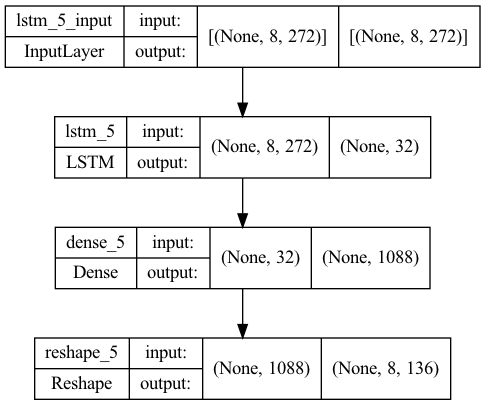

In [167]:
tf.keras.utils.plot_model(multi_lstm_model, "../plots/models/multi_lstm_model.png", show_shapes=True)

label_col_index 135


2022-08-29 17:58:53.092072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-29 17:58:53.149692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


label_col_index 135
label_col_index 135


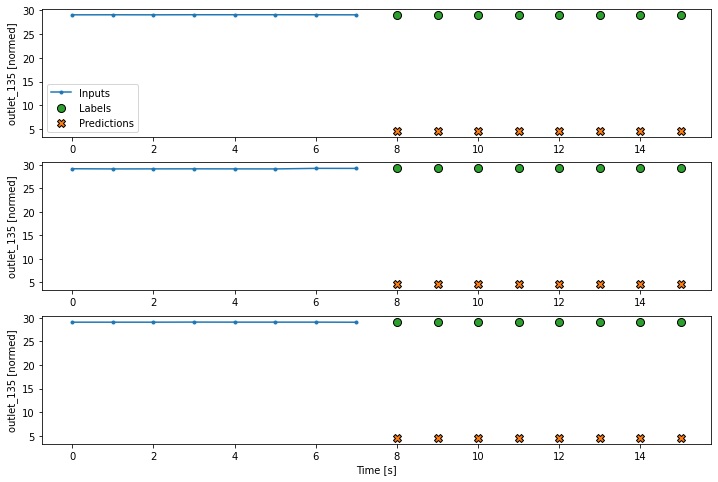

In [168]:
window.plot(multi_lstm_model, plot_col="outlet_135")

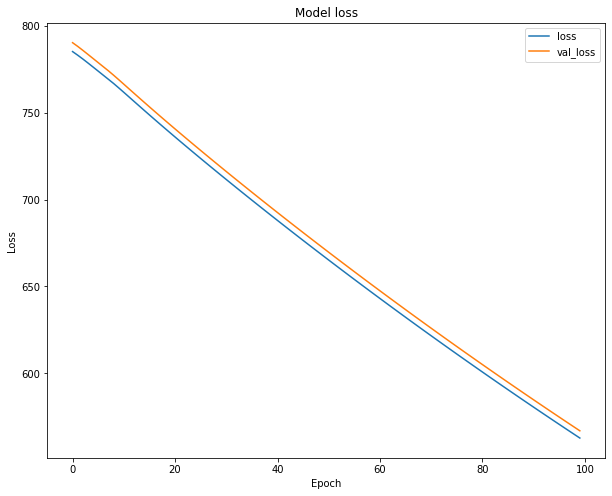

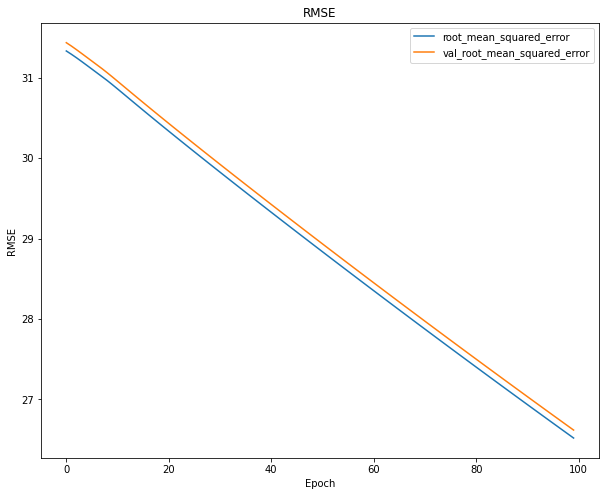

In [169]:
plot_losses(history=history)

In [170]:
multi_lstm_model.evaluate(window.test)

1/1 [==============================] - 0s 256ms/step - loss: 566.3954 - root_mean_squared_error: 26.6176


[566.3953857421875, 26.617599487304688]

## Case 2

In [172]:
window, history = train_case(
    case_df=case_2,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

{'loss': [408.21337890625,
  406.686279296875,
  405.1998596191406,
  403.4504699707031,
  401.5499267578125,
  399.6125793457031,
  397.68365478515625,
  395.77935791015625,
  393.905517578125,
  392.06298828125,
  390.25067138671875,
  388.46649169921875,
  386.7082214355469,
  384.9737243652344,
  383.2607727050781,
  381.5679016113281,
  379.8933410644531,
  378.23553466796875,
  376.593505859375,
  374.9659118652344,
  373.35211181640625,
  371.7510681152344,
  370.162109375,
  368.58477783203125,
  367.01812744140625,
  365.4620056152344,
  363.9158630371094,
  362.3792419433594,
  360.85174560546875,
  359.3333435058594,
  357.8233642578125,
  356.32183837890625,
  354.8282470703125,
  353.3426513671875,
  351.8645324707031,
  350.39398193359375,
  348.9307556152344,
  347.4745788574219,
  346.0253601074219,
  344.58306884765625,
  343.1475524902344,
  341.7183837890625,
  340.29583740234375,
  338.8797302246094,
  337.4698181152344,
  336.0660705566406,
  334.6683654785156,
  3

label_col_index 135
label_col_index 135
label_col_index 135


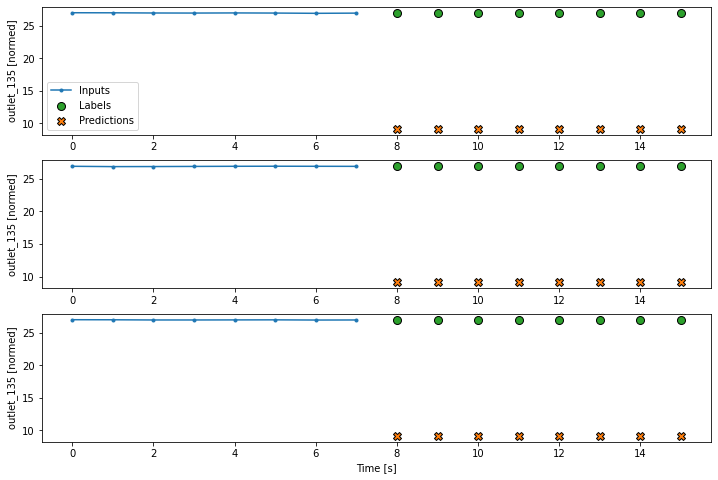

In [141]:
window.plot(multi_lstm_model, plot_col="outlet_135")

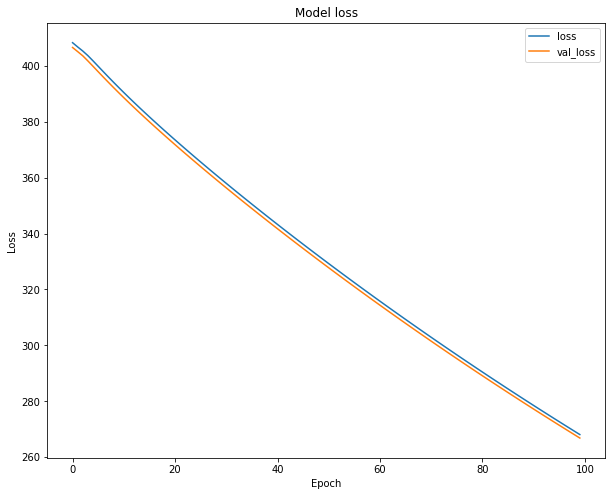

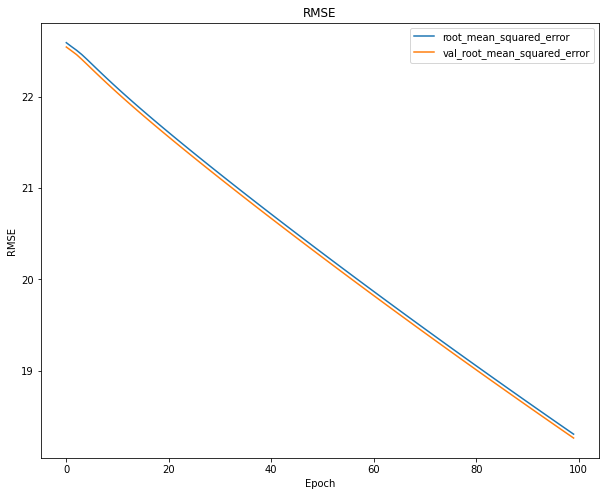

In [142]:
plot_losses(history=history)

In [143]:
multi_lstm_model.evaluate(window.test)

1/1 [==============================] - 0s 306ms/step - loss: 269.0127 - root_mean_squared_error: 18.3381


[269.0126647949219, 18.338083267211914]

## Case 3

In [144]:
window, history = train_case(
    case_df=case_3,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


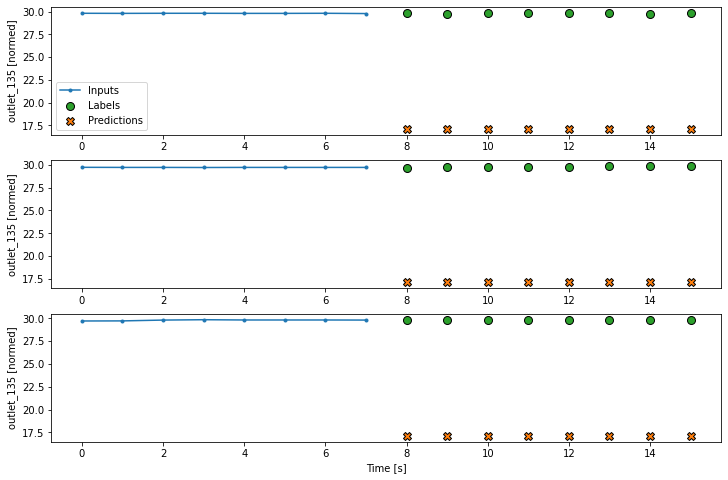

In [145]:
window.plot(multi_lstm_model, plot_col="outlet_135")

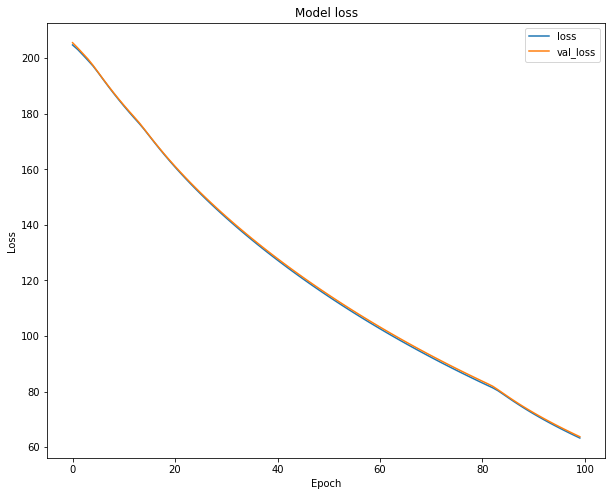

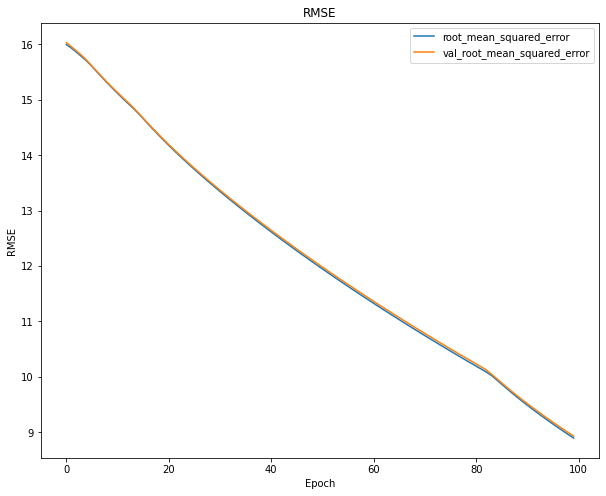

In [146]:
plot_losses(history=history)

In [147]:
multi_lstm_model.evaluate(window.test)

1/1 [==============================] - 0s 270ms/step - loss: 63.2665 - root_mean_squared_error: 8.8834


[63.26649856567383, 8.883448600769043]

## Case 4

In [148]:
window, history = train_case(
    case_df=case_4,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


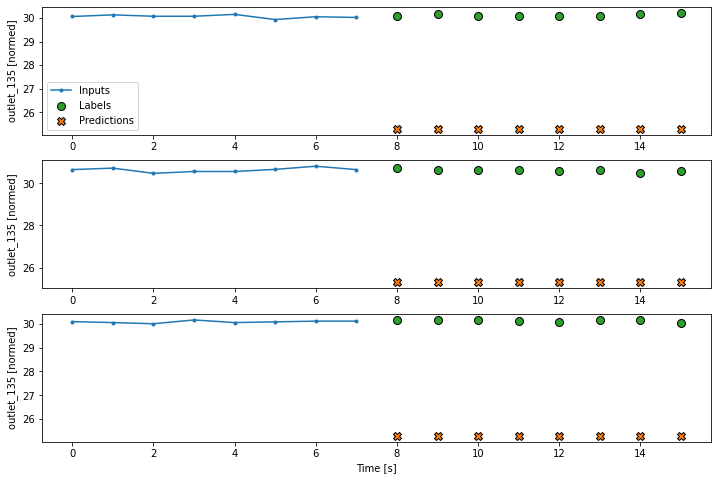

In [149]:
window.plot(multi_lstm_model, plot_col="outlet_135")

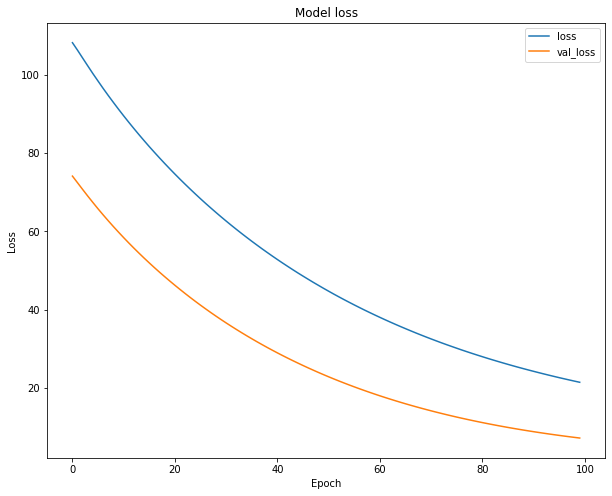

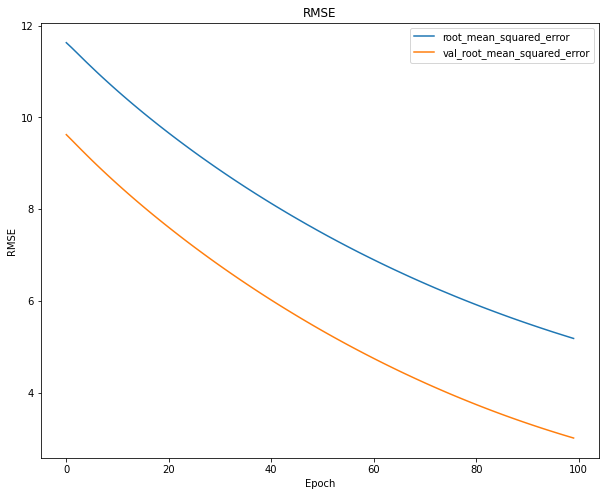

In [150]:
plot_losses(history=history)

In [151]:
multi_lstm_model.evaluate(window.test)

1/1 [==============================] - 0s 297ms/step - loss: 7.3744 - root_mean_squared_error: 3.0361


[7.374373912811279, 3.0361177921295166]

## Case 5

In [152]:
window, history = train_case(
    case_df=case_5,
    model=multi_lstm_model,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

label_col_index 135
label_col_index 135
label_col_index 135


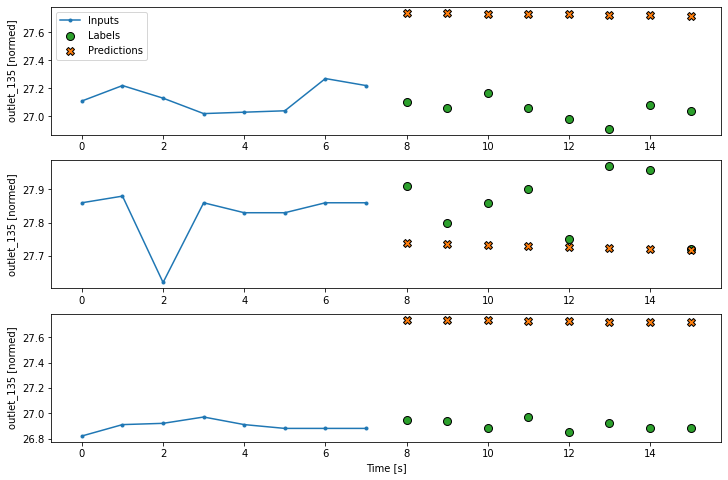

In [153]:
window.plot(multi_lstm_model, plot_col="outlet_135")

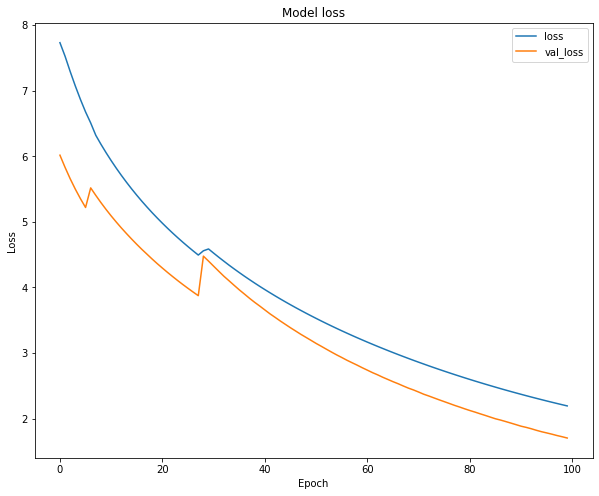

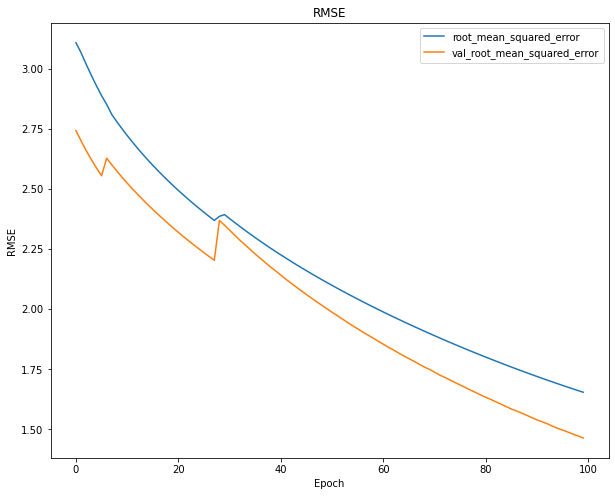

In [154]:
plot_losses(history=history)

In [155]:
multi_lstm_model.evaluate(window.test)

2/2 [==============================] - 0s 7ms/step - loss: 2.7856 - root_mean_squared_error: 1.8698


[2.785568952560425, 1.8698492050170898]